<a href="https://colab.research.google.com/github/mateopolancecofficial/WineReviews/blob/main/ANNComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone -l -s https://github.com/mateopolancecofficial/WineReviews.git

fatal: destination path 'WineReviews' already exists and is not an empty directory.


In [4]:
pip install -q -U tensorflow-text

     |████████████████████████████████| 3.4MB 22.8MB/s 


In [5]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 8.9MB/s 


In [6]:
pip install -q -U tf-models-official

     |████████████████████████████████| 1.1MB 19.1MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 174kB 40.9MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 645kB 49.2MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 1.2MB 42.2MB/s 
     |████████████████████████████████| 358kB 59.8MB/s 
     |████████████████████████████████| 706kB 37.9MB/s 


## DNN regressors


We will train and compare two following models:

1.) RNN model
   - The first layer is the encoder, which converts the text to a sequence of token indices.
   - After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.
   - A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep. RNN will convert the sequence to a single vector.
   - Add few Dense and Dropout layers for prediction target variable

2.) TF HUB model
  - Add pretrained model from tensorflow hub for converting text to numerical vector (sequence embeddings)
  - pretrained model will be fine tuned during training process
  - Add few Dense and Dropout layers for prediction target variable

For both models hyperparameters tuning will be made and best parameters will be used in training process.

Finally, for comparison mean absolute error and r2_score will be visualized for both models.

In [7]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Input
)
import kerastuner as kt
from official.nlp import optimization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

tf.get_logger().setLevel('ERROR')
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"


In [8]:
import os

if tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')

Using GPU


### Load dataset and set global parameters

Before text encoding and generating sequence embeddings we need to load dataset, make train, validation and test splits and load it into tensorflow dataset.

In [9]:
# set parameters
AUTOTUNE = tf.data.AUTOTUNE
path_v1 = "/content/WineReviews/Data/winemag-data-130k-v2.csv" 
path_v2 = "/content/WineReviews/Data/winemag-data_first150k.csv"
batch_size = 2048
col_idx = 0
train_size, test_size, val_size = 0.8, 0.2, 0.2
transform = 'normalize'
columns = ['description', 'points']

In [10]:
def load_data(path_v1: str, path_v2: str, columns: list, col_idx: int):
  """
  Load and concatenate two datasets with removing duplicates.
  param path_v1: import path of first dataset
  param path_v2: import path of second dataset
  param columns: list of columns to preserve in dataframe
  param col_idx: index of column given in input columns list 
                 on which look for duplicates in dataframe
  return:        pandas dataframe
  """
  
  df_v1 = pd.read_csv(path_v1, index_col=0)
  df_v1 = df_v1[columns]
  # remove numbers form column description from first dataframe
  df_v1.description = df_v1.description.str.replace('\d+', '')

  df_v2 = pd.read_csv(path_v2, index_col=0)
  df_v2 = df_v2[columns]
  # remove numbers form column description from second dataframe
  df_v2.description = df_v2.description.str.replace('\d+', '')

  df = pd.concat([df_v1, df_v2])

  # dropping duplicte values
  df.drop_duplicates(subset = columns[col_idx],
                       keep = 'first', inplace = True)
  
  return df

In [11]:
def split_data(df: pd.DataFrame, train_size: float, test_size: float, 
               val_size: float):
  """
  Split dataset on train, test and validation subsets.
  param df:          input dataframe
  param train_size:  fraction of train size
  param test_size:   fraction of test size
  param val_size:    fraction of validation size
  return:            dictionary, keys=names of dataframes, columns=dataframes
  """
  
  # shuffle dataset
  df = df.sample(frac = 1)
  
  # split on test and train set
  text_train, text_test, y_train, y_test = train_test_split(df.description, df.points,
                                           test_size=test_size, train_size=train_size)
  
  y_train, y_test = y_train.astype('float'), y_test.astype('float')
  
  # split train set on train and validation subsets
  text_train, text_val, y_train, y_val = train_test_split(text_train, y_train,
                                                  test_size=val_size, train_size=train_size)
  
  y_train, y_val = y_train.astype('float'), y_val.astype('float')

  y_train = y_train.to_numpy().reshape(-1, 1)
  y_val = y_val.to_numpy().reshape(-1, 1)
  y_test = y_test.to_numpy().reshape(-1, 1)

  # apply target variable transformation
  if transform == 'normalize':
    scaler = MinMaxScaler()
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_val = scaler.transform(y_val)
    y_test = scaler.transform(y_test)
    
  elif transform == 'standardize':
    scaler = StandardScaler()
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_val = scaler.transform(y_val)
    y_test = scaler.transform(y_test)
    
  else:
    scaler = MinMaxScaler()
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_val = scaler.transform(y_val)
    y_test = scaler.transform(y_test)
  
  y_train, y_val, y_test = y_train.ravel(), y_val.ravel(), y_test.ravel()

  dataset_dict = {
      'text_train': text_train,
      'y_train': y_train,
      'text_val': text_val,
      'y_val': y_val,
      'text_test': text_test,
      'y_test': y_test,
      'scaler': scaler
  }

  return dataset_dict

In [12]:
def create_input_datasets(df_data: dict):
  """
  Create tensorflow datasets based on input dataframes for train, validation 
  and test subsets.
  param df_data: dictionary, keys=names of dataframes, columns=dataframes
  return:        dictionary, keys=names of datasets, columns=datasets
  """

  # create train dataset for input in tensorflow model
  train_dataset = tf.data.Dataset.from_tensor_slices((df_data['text_train'], 
                                                      df_data['y_train']))
  train_dataset = train_dataset.batch(batch_size)
  train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  # create validation dataset for input in tensorflow model
  val_dataset = tf.data.Dataset.from_tensor_slices((df_data['text_val'], 
                                                    df_data['y_val']))
  val_dataset = val_dataset.batch(batch_size)
  val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  # create validation dataset for input in tensorflow model
  test_dataset = tf.data.Dataset.from_tensor_slices((df_data['text_test'], 
                                                     df_data['y_test']))
  test_dataset = test_dataset.batch(batch_size)
  test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  datasets = {
      'train_dataset': train_dataset,
      'val_dataset': val_dataset,
      'test_dataset': test_dataset
  } 

  return datasets

In [14]:
# call data transformation functions
df = load_data(path_v1, path_v2, columns, col_idx)
df_data = split_data(df, train_size, test_size, val_size)
datasets = create_input_datasets(df_data)

In [15]:
# define loss functions
from tensorflow.keras import backend as K

def rmse():
  def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
  return root_mean_squared_error

def rmsle():
  def root_mean_squared_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(1+y_pred) - K.log(1+y_true))))
  return root_mean_squared_log_error

### RNN model

TextVectorization (standardization, tokenization, vectorization)
   - Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

In [16]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(datasets['train_dataset'].map(lambda text, label: text))

In [17]:
# disable eager execution
tf.config.run_functions_eagerly(False)

def rnn_model_builder(hp):
  model = tf.keras.Sequential()
  model.add(encoder)
  model.add(tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
  hp_units_1 = hp.Int('units_1', min_value=64, max_value=128, step=16)
  activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid'],
        default='relu'
    )
  model.add(Dense(units=hp_units_1, activation=activation))
  model.add(
            Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.1,
                max_value=0.5,
                default=0.25,
                step=0.1,
            ))
        )
  hp_units_2 = hp.Int('units_2', min_value=8, max_value=64, step=16)
  model.add(Dense(units=hp_units_2, activation=activation))
  model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.1,
                max_value=0.5,
                default=0.25,
                step=0.1,
            ))
        )
  model.add(Dense(1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=rmse(),
              metrics=['mean_absolute_error'])

  return model

In [18]:
# define early stop callback to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [19]:
rnn_tuner = kt.Hyperband(rnn_model_builder,
                         objective='mean_absolute_error',
                         max_epochs=5,
                         directory='RNN'
                         )

In [ ]:
rnn_tuner.search(df_data['text_train'], df_data['y_train'], 
                 validation_data=(df_data['text_val'], df_data['y_val']), 
                 epochs=5, callbacks=[stop_early])

# get optimal hyperparameters
rnn_best_hps = rnn_tuner.get_best_hyperparameters(num_trials=1)[0]

In [22]:
rnn_model = rnn_tuner.hypermodel.build(rnn_best_hps)

In [23]:
# checkpoints callback is not defined because a lack of disk space on Google Colab
rnn_history = rnn_model.fit(datasets['train_dataset'],
                            validation_data=datasets['val_dataset'],
                            epochs=100,
                            callbacks=[stop_early]
                            )

Epoch 1/100
53/53 [==============================] - 30s 297ms/step - loss: 0.2156 - mean_absolute_error: 0.1807 - val_loss: 0.1065 - val_mean_absolute_error: 0.0839
Epoch 2/100
53/53 [==============================] - 12s 229ms/step - loss: 0.1220 - mean_absolute_error: 0.0960 - val_loss: 0.0966 - val_mean_absolute_error: 0.0760
Epoch 3/100
53/53 [==============================] - 12s 229ms/step - loss: 0.1115 - mean_absolute_error: 0.0879 - val_loss: 0.0933 - val_mean_absolute_error: 0.0734
Epoch 4/100
53/53 [==============================] - 12s 230ms/step - loss: 0.1080 - mean_absolute_error: 0.0850 - val_loss: 0.0931 - val_mean_absolute_error: 0.0732
Epoch 5/100
53/53 [==============================] - 12s 231ms/step - loss: 0.1049 - mean_absolute_error: 0.0826 - val_loss: 0.0937 - val_mean_absolute_error: 0.0735
Epoch 6/100
53/53 [==============================] - 12s 232ms/step - loss: 0.1031 - mean_absolute_error: 0.0812 - val_loss: 0.0913 - val_mean_absolute_error: 0.0718
Epoc

### Use a pre-trained text embedding as the first layer

For this example we will use a pre-trained text embedding model from TensorFlow Hub called 
google/nnlm-en-dim128-with-normalization/2.

In [24]:
# disable eager execution
tf.config.run_functions_eagerly(False)

def tf_model_builder(hp):
  # use pretrained embeddings for input layer
  hub_model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
  # 'trainable=True' - boolean controlling whether this layer is trainable
  hub_layer = hub.KerasLayer(hub_model, input_shape=[], dtype=tf.string, 
                             trainable=True)
  model = tf.keras.Sequential()
  model.add(hub_layer)
  hp_units_1 = hp.Int('units_1', min_value=64, max_value=128, step=16)
  activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid'],
        default='relu'
    )
  model.add(Dense(units=hp_units_1, activation=activation))
  model.add(
            Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.1,
                max_value=0.5,
                default=0.25,
                step=0.1,
            ))
        )
  hp_units_2 = hp.Int('units_2', min_value=8, max_value=64, step=16)
  model.add(Dense(units=hp_units_2, activation=activation))
  model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.1,
                max_value=0.5,
                default=0.25,
                step=0.1,
            ))
        )
  model.add(Dense(1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=rmse(),
              metrics=['mean_absolute_error'])

  return model

In [25]:
# define early stop callback to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [26]:
tf_tuner = kt.Hyperband(tf_model_builder,
                        objective='mean_absolute_error',
                        max_epochs=5,
                        directory='TF'
                       )

In [27]:
tf_tuner.search(df_data['text_train'], df_data['y_train'], 
                validation_data=(df_data['text_val'], df_data['y_val']), 
                epochs=5, callbacks=[stop_early])

# Get the optimal hyperparameters
tf_best_hps = tf_tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 20m 39s]
mean_absolute_error: 0.05979585275053978

Best mean_absolute_error So Far: 0.05979585275053978
Total elapsed time: 02h 08m 19s


In [28]:
tf_model = tf_tuner.hypermodel.build(tf_best_hps)


In [29]:
# checkpoints callback is not defined because a lack of disk space on Google Colab
tf_history = tf_model.fit(datasets['train_dataset'],
                          validation_data=datasets['val_dataset'],
                          epochs=100,
                          callbacks=[stop_early]
                          )

Epoch 1/100
53/53 [==============================] - 5s 90ms/step - loss: 0.4759 - mean_absolute_error: 0.3804 - val_loss: 0.1452 - val_mean_absolute_error: 0.1172
Epoch 2/100
53/53 [==============================] - 5s 89ms/step - loss: 0.1769 - mean_absolute_error: 0.1414 - val_loss: 0.1133 - val_mean_absolute_error: 0.0904
Epoch 3/100
53/53 [==============================] - 5s 88ms/step - loss: 0.1329 - mean_absolute_error: 0.1054 - val_loss: 0.0976 - val_mean_absolute_error: 0.0771
Epoch 4/100
53/53 [==============================] - 5s 89ms/step - loss: 0.1146 - mean_absolute_error: 0.0906 - val_loss: 0.0925 - val_mean_absolute_error: 0.0731
Epoch 5/100
53/53 [==============================] - 5s 93ms/step - loss: 0.1057 - mean_absolute_error: 0.0835 - val_loss: 0.0906 - val_mean_absolute_error: 0.0715
Epoch 6/100
53/53 [==============================] - 5s 93ms/step - loss: 0.1000 - mean_absolute_error: 0.0790 - val_loss: 0.0897 - val_mean_absolute_error: 0.0707
Epoch 7/100
53/5

### Visualize results

In [30]:
y_real = df_data['scaler'].inverse_transform(df_data['y_test'].reshape(-1, 1))

rnn_result = rnn_model.predict(df_data['text_test'])
y_predict_rnn = df_data['scaler'].inverse_transform(rnn_result.reshape(-1, 1))

tf_result = tf_model.predict(df_data['text_test'])
y_predict_tf = df_data['scaler'].inverse_transform(tf_result.reshape(-1, 1))

In [32]:
from sklearn.metrics import r2_score, mean_absolute_error


estimators = {'RNN': 
              {
                  'mae': mean_absolute_error(y_real, y_predict_rnn),
                  'r2_score': r2_score(y_real, y_predict_rnn),
                  'y_predict': y_predict_rnn
              },
              'TF': 
              {
                  'mae': mean_absolute_error(y_real, y_predict_tf),
                  'r2_score': r2_score(y_real, y_predict_tf),
                  'y_predict': y_predict_tf
              }
             }

In [33]:
def plot_regression_results(ax, y_true, y_pred, title, scores):
    """Scatter plot of the predicted vs true targets. """
    
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title
    ax.set_title(title)

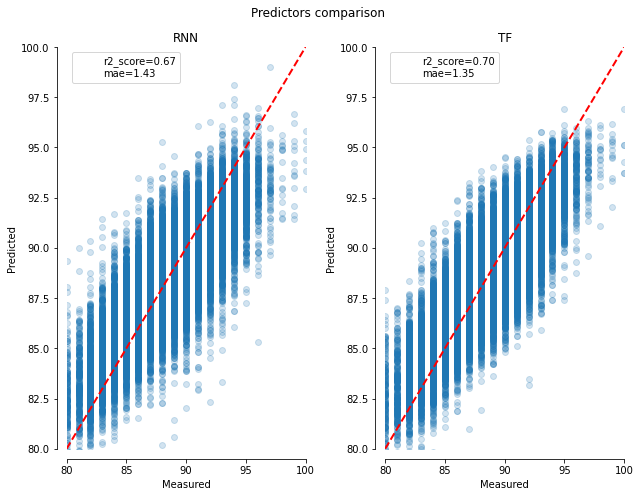

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, name in zip(axs, list(estimators.keys())):
    
    plot_regression_results(
        ax, y_real, estimators[name]['y_predict'],
        name,
        (r'r2_score={:.2f}' + '\n' + r'mae={:.2f}')
        .format(estimators[name]['r2_score'],
                estimators[name]['mae']))

plt.suptitle('Predictors comparison ')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Conclusion

- both models have similar scores
- mean absolute error is decreased in comparison with TF-IDF features used with ensemble methods and approximately average error on validation dataset is 7%
- r2_score is much higher using sequence embeddings than using just TF_IDF encoders
- results are promising and further improvement in ANN arhitectures with more input data will lead to better results